In [1]:
!pip install memory-profiler
!pip install tracemalloc

ERROR: Could not find a version that satisfies the requirement tracemalloc (from versions: none)
ERROR: No matching distribution found for tracemalloc


In [2]:
import os
import time
import psutil
import warnings
warnings.filterwarnings('ignore')

# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, accuracy_score, 
                           confusion_matrix, precision_recall_fscore_support)

# Models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Memory and performance monitoring
import gc
from memory_profiler import profile
import tracemalloc

print("All libraries imported successfully!")


2025-09-12 10:59:59.039105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757674799.272407      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757674799.343395      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!


In [3]:
SEED=331

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/luflow-modified-dataset/luflow_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Select only the specified features from the Joy tool
feature_columns = [
    'src_ip', 'src_port', 'dest_ip', 'dest_port', 'proto',  # protocol renamed to proto in dataset
    'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out', 
    'entropy', 'total_entropy', 'avg_ipt',  # mean_ipt renamed to avg_ipt in dataset
    'time_start', 'time_end', 'duration'
]

# Check available columns and adjust if necessary
print("Available columns:", df.columns.tolist())

# Ensure we have all required features
available_features = [col for col in feature_columns if col in df.columns]
print(f"Using features: {available_features}")

# Select features and target
X = df[available_features].copy()
y = df['label'].copy()

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Dataset shape: (7890694, 17)
Memory usage: 1889.78 MB
Available columns: ['avg_ipt', 'bytes_in', 'bytes_out', 'dest_ip', 'dest_port', 'entropy', 'num_pkts_out', 'num_pkts_in', 'proto', 'src_ip', 'src_port', 'time_end', 'time_start', 'total_entropy', 'label', 'duration', 'source_file']
Using features: ['src_ip', 'src_port', 'dest_ip', 'dest_port', 'proto', 'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out', 'entropy', 'total_entropy', 'avg_ipt', 'time_start', 'time_end', 'duration']
Features shape: (7890694, 15)
Target distribution:
label
benign       4243325
malicious    2628641
outlier      1018728
Name: count, dtype: int64


In [5]:
# Handle missing values
print("Missing values per column:")
print(X.isnull().sum())

# Get indices of rows with missing values
missing_indices = X.isnull().any(axis=1)
print(f"Rows with missing values: {missing_indices.sum()}")

# Drop missing value rows from BOTH X and y consistently
valid_indices = ~missing_indices
X_clean = X[valid_indices].copy()
y_clean = y[valid_indices].copy()

print(f"After removing missing values:")
print(f"X shape: {X_clean.shape}")
print(f"y shape: {y_clean.shape}")

# Handle potential infinite values
inf_mask = np.isinf(X_clean).any(axis=1)
print(f"Rows with infinite values: {inf_mask.sum()}")

if inf_mask.sum() > 0:
    final_valid_indices = ~inf_mask
    X_clean = X_clean[final_valid_indices].copy()
    y_clean = y_clean[final_valid_indices].copy()
    print(f"After removing infinite values:")
    print(f"X shape: {X_clean.shape}")
    print(f"y shape: {y_clean.shape}")

# Verify alignment
assert len(X_clean) == len(y_clean), f"Size mismatch: X={len(X_clean)}, y={len(y_clean)}"

# Encode target labels
label_encoder = LabelEncoder()
y_encoded_clean = label_encoder.fit_transform(y_clean)
print(f"Label classes: {label_encoder.classes_}")
print(f"Final encoded distribution: {np.bincount(y_encoded_clean)}")

# Feature scaling for neural network (we'll apply selectively)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns, index=X_clean.index)

# Update variable names for consistency
X = X_clean
y_encoded = y_encoded_clean

print("Data preprocessing completed!")

Missing values per column:
src_ip                0
src_port         121376
dest_ip               0
dest_port        121376
proto                 0
bytes_in              0
bytes_out             0
num_pkts_in           0
num_pkts_out          0
entropy               0
total_entropy         0
avg_ipt               0
time_start            0
time_end              0
duration              0
dtype: int64
Rows with missing values: 121376
After removing missing values:
X shape: (7769318, 15)
y shape: (7769318,)
Rows with infinite values: 0
Label classes: ['benign' 'malicious' 'outlier']
Final encoded distribution: [4243278 2529308  996732]
Data preprocessing completed!


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set distribution: {np.bincount(y_train)}")
print(f"Test set distribution: {np.bincount(y_test)}")

# Memory optimization - reduce data types where possible
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

X_train = optimize_dtypes(X_train)
X_test = optimize_dtypes(X_test)
X_train_scaled = optimize_dtypes(X_train_scaled)
X_test_scaled = optimize_dtypes(X_test_scaled)

print("Data splitting and optimization completed!")


Training set shape: (6215454, 15)
Test set shape: (1553864, 15)
Training set distribution: [3394622 2023446  797386]
Test set distribution: [848656 505862 199346]
Data splitting and optimization completed!


In [7]:
def measure_performance(model, X_test, y_test, model_name):
    """Measure model performance with accurate memory tracking"""
    
    # Force garbage collection before measurement
    gc.collect()
    
    # Start memory tracing
    tracemalloc.start()
    
    # Measure inference time and memory together
    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()
    
    # Get peak memory usage during prediction
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # Calculate metrics
    inference_time = end_time - start_time
    avg_inference_per_sample = inference_time / len(X_test) * 1000  # ms per sample
    memory_used_mb = peak / 1024**2  # Convert to MB
    
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Total_Inference_Time_s': inference_time,
        'Avg_Inference_ms_per_sample': avg_inference_per_sample,
        'Memory_Used_MB': memory_used_mb,
        'Predictions': predictions
    }
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Total Inference Time: {inference_time:.4f}s")
    print(f"Avg Inference per Sample: {avg_inference_per_sample:.4f}ms")
    print(f"Peak Memory Used: {memory_used_mb:.2f}MB")
    
    return results


def print_classification_report(y_true, y_pred, model_name):
    """Print detailed classification report"""
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("Performance monitoring functions defined!")


Performance monitoring functions defined!


In [8]:
print("Training Random Forest (Baseline)...")

# Random Forest with optimized hyperparameters for speed vs accuracy
rf_model = RandomForestClassifier(
    n_estimators=120,        # Sweet spot for accuracy vs speed
    max_depth=22,           # Sufficient for LUFlow complexity
    min_samples_split=6,    # Balanced splitting
    min_samples_leaf=3,     # Fine-grained decisions
    max_features='sqrt',    # 4 features per split
    bootstrap=True,
    class_weight={0: 1.0, 1: 1.6, 2: 4.2} ,
    random_state=SEED,
    n_jobs=-1,
    
    # Additional optimizations for edge deployment:
    warm_start=False,       # Don't incrementally add trees
    oob_score=False,        # Skip out-of-bag scoring for speed
)

# Train the model
start_train = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_train

print(f"Training completed in {train_time:.2f} seconds")

# Evaluate performance
rf_results = measure_performance(rf_model, X_test, y_test, "Random Forest")
print_classification_report(y_test, rf_results['Predictions'], "Random Forest")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Important Features:")
print(feature_importance.head())

# Cleanup
gc.collect()


Training Random Forest (Baseline)...
Training completed in 818.87 seconds

Random Forest Performance:
Accuracy: 0.9497
F1-Score: 0.9512
Total Inference Time: 17.6924s
Avg Inference per Sample: 0.0114ms
Peak Memory Used: 318.76MB

Random Forest - Detailed Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    848656
   malicious       0.97      0.87      0.92    505862
     outlier       0.74      0.93      0.83    199346

    accuracy                           0.95   1553864
   macro avg       0.90      0.93      0.91   1553864
weighted avg       0.96      0.95      0.95   1553864


Top 5 Important Features:
          feature  importance
3       dest_port    0.243479
0          src_ip    0.153018
10  total_entropy    0.090735
6       bytes_out    0.079119
12     time_start    0.074822


48

In [9]:
print("Training XGBoost...")

# XGBoost with optimized parameters for speed and accuracy
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1,
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model
start_train = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_train

print(f"Training completed in {train_time:.2f} seconds")

# Evaluate performance
xgb_results = measure_performance(xgb_model, X_test, y_test, "XGBoost")
print_classification_report(y_test, xgb_results['Predictions'], "XGBoost")

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Important Features:")
print(xgb_importance.head())

# Cleanup
gc.collect()


Training XGBoost...
Training completed in 145.27 seconds

XGBoost Performance:
Accuracy: 0.9113
F1-Score: 0.9048
Total Inference Time: 4.6714s
Avg Inference per Sample: 0.0030ms
Peak Memory Used: 195.64MB

XGBoost - Detailed Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    848656
   malicious       0.82      0.93      0.87    505862
     outlier       0.74      0.48      0.58    199346

    accuracy                           0.91   1553864
   macro avg       0.85      0.80      0.82   1553864
weighted avg       0.91      0.91      0.90   1553864


Top 5 Important Features:
          feature  importance
3       dest_port    0.458792
1        src_port    0.107755
0          src_ip    0.103042
10  total_entropy    0.077707
2         dest_ip    0.055910


0

In [10]:
print("Training LightGBM...")

# LightGBM with optimized parameters for speed
lgb_model = lgb.LGBMClassifier(
    n_estimators=150,        # More trees for better learning
    max_depth=8,            # Deeper for complex patterns  
    learning_rate=0.05,     # Slower, more stable learning
    num_leaves=63,          # Finer granularity
    class_weight='balanced', # Handle imbalance
    objective='multiclass', # Explicit 3-class problem
    metric='multi_logloss', # Proper evaluation
    random_state=SEED,        # Reproducibility
    n_jobs=-1,             # Use all cores
    verbose=-1             # Suppress output
)

# Train the model
start_train = time.time()
lgb_model.fit(X_train, y_train)
train_time = time.time() - start_train

print(f"Training completed in {train_time:.2f} seconds")

# Evaluate performance
lgb_results = measure_performance(lgb_model, X_test, y_test, "LightGBM")
print_classification_report(y_test, lgb_results['Predictions'], "LightGBM")

# Feature importance
lgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Important Features:")
print(lgb_importance.head())

# Cleanup
gc.collect()


Training LightGBM...
Training completed in 156.86 seconds

LightGBM Performance:
Accuracy: 0.9091
F1-Score: 0.9132
Total Inference Time: 21.2293s
Avg Inference per Sample: 0.0137ms
Peak Memory Used: 391.24MB

LightGBM - Detailed Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    848656
   malicious       0.94      0.77      0.85    505862
     outlier       0.60      0.88      0.71    199346

    accuracy                           0.91   1553864
   macro avg       0.85      0.88      0.85   1553864
weighted avg       0.93      0.91      0.91   1553864


Top 5 Important Features:
       feature  importance
0       src_ip        5579
13    time_end        3640
12  time_start        3625
3    dest_port        3125
1     src_port        2656


6

In [11]:
print("Training Lightweight DNN...")

# Convert target to categorical for neural network
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Define lightweight DNN architecture
def create_lightweight_dnn(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(), 
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and train model
dnn_model = create_lightweight_dnn(X_train_scaled.shape[1], len(label_encoder.classes_))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Model architecture:")
dnn_model.summary()

# Train the model
start_train = time.time()
history = dnn_model.fit(
    X_train_scaled, y_train_cat,
    batch_size=1024,  # Larger batch size for speed
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
    class_weight={0: 1.0, 1: 1.6, 2: 4.2}
)
train_time = time.time() - start_train

print(f"Training completed in {train_time:.2f} seconds")

# Convert DNN predictions back to single labels
def predict_dnn(model, X):
    predictions_prob = model.predict(X, batch_size=1024)
    return np.argmax(predictions_prob, axis=1)

# Create a wrapper for consistent interface
class DNNWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        return predict_dnn(self.model, X)

dnn_wrapper = DNNWrapper(dnn_model)

# Evaluate performance
dnn_results = measure_performance(dnn_wrapper, X_test_scaled, y_test, "Lightweight DNN")
print_classification_report(y_test, dnn_results['Predictions'], "Lightweight DNN")

# Cleanup
gc.collect()


Training Lightweight DNN...
Model architecture:


2025-09-12 11:20:43.144145: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 12,867 (50.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - accuracy: 0.6831 - loss: 1.1421 - val_accuracy: 0.7571 - val_loss: 0.3335
Epoch 2/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.7755 - loss: 0.7752 - val_accuracy: 0.7992 - val_loss: 0.3156
Epoch 3/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.7949 - loss: 0.7389 - val_accuracy: 0.8239 - val_loss: 0.3026
Epoch 4/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.8177 - loss: 0.7136 - val_accuracy: 0.8290 - val_loss: 0.2948
Epoch 5/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.8283 - loss: 0.6933 - val_accuracy: 0.8283 - val_loss: 0.2914
Epoch 6/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.8323 - loss: 0.6806 - val_accuracy: 0.8360 - val_loss: 0.2841
Epoch 7/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - accuracy: 0.8341 - loss: 0.6728 - val_accuracy: 0.8423 - val_loss: 0.2788
Epoch 8/50
4856/4856 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.8364 -

501

In [12]:
# Compile all results
all_results = [rf_results, xgb_results, lgb_results, dnn_results]
comparison_df = pd.DataFrame(all_results)

# Remove predictions column for cleaner display
display_df = comparison_df.drop('Predictions', axis=1)
print("Model Performance Comparison:")
print("=" * 100)
print(display_df.to_string(index=False, float_format='%.4f'))

# Identify models meeting accuracy threshold
accuracy_threshold = 0.90
qualifying_models = display_df[display_df['Accuracy'] >= accuracy_threshold]

print(f"\nModels meeting ≥90% accuracy threshold:")
print("=" * 50)
if len(qualifying_models) > 0:
    print(qualifying_models[['Model', 'Accuracy', 'Avg_Inference_ms_per_sample', 'Memory_Used_MB']].to_string(index=False))
    
    # Find the best model for deployment (highest accuracy, fastest inference)
    best_model = qualifying_models.loc[qualifying_models['Avg_Inference_ms_per_sample'].idxmin()]
    print(f"\nRecommended model for deployment: {best_model['Model']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"Avg inference: {best_model['Avg_Inference_ms_per_sample']:.4f} ms/sample")
    print(f"Memory usage: {best_model['Memory_Used_MB']:.2f} MB")
else:
    print("No models meet the 90% accuracy threshold")


Model Performance Comparison:
          Model  Accuracy  Precision  Recall  F1_Score  Total_Inference_Time_s  Avg_Inference_ms_per_sample  Memory_Used_MB
  Random Forest    0.9497     0.9568  0.9497    0.9512                 17.6924                       0.0114        318.7567
        XGBoost    0.9113     0.9077  0.9113    0.9048                  4.6714                       0.0030        195.6362
       LightGBM    0.9091     0.9301  0.9091    0.9132                 21.2293                       0.0137        391.2374
Lightweight DNN    0.8595     0.8960  0.8595    0.8664                  9.6344                       0.0062        178.0162

Models meeting ≥90% accuracy threshold:
        Model  Accuracy  Avg_Inference_ms_per_sample  Memory_Used_MB
Random Forest  0.949688                     0.011386      318.756685
      XGBoost  0.911317                     0.003006      195.636186
     LightGBM  0.909134                     0.013662      391.237423

Recommended model for deployment

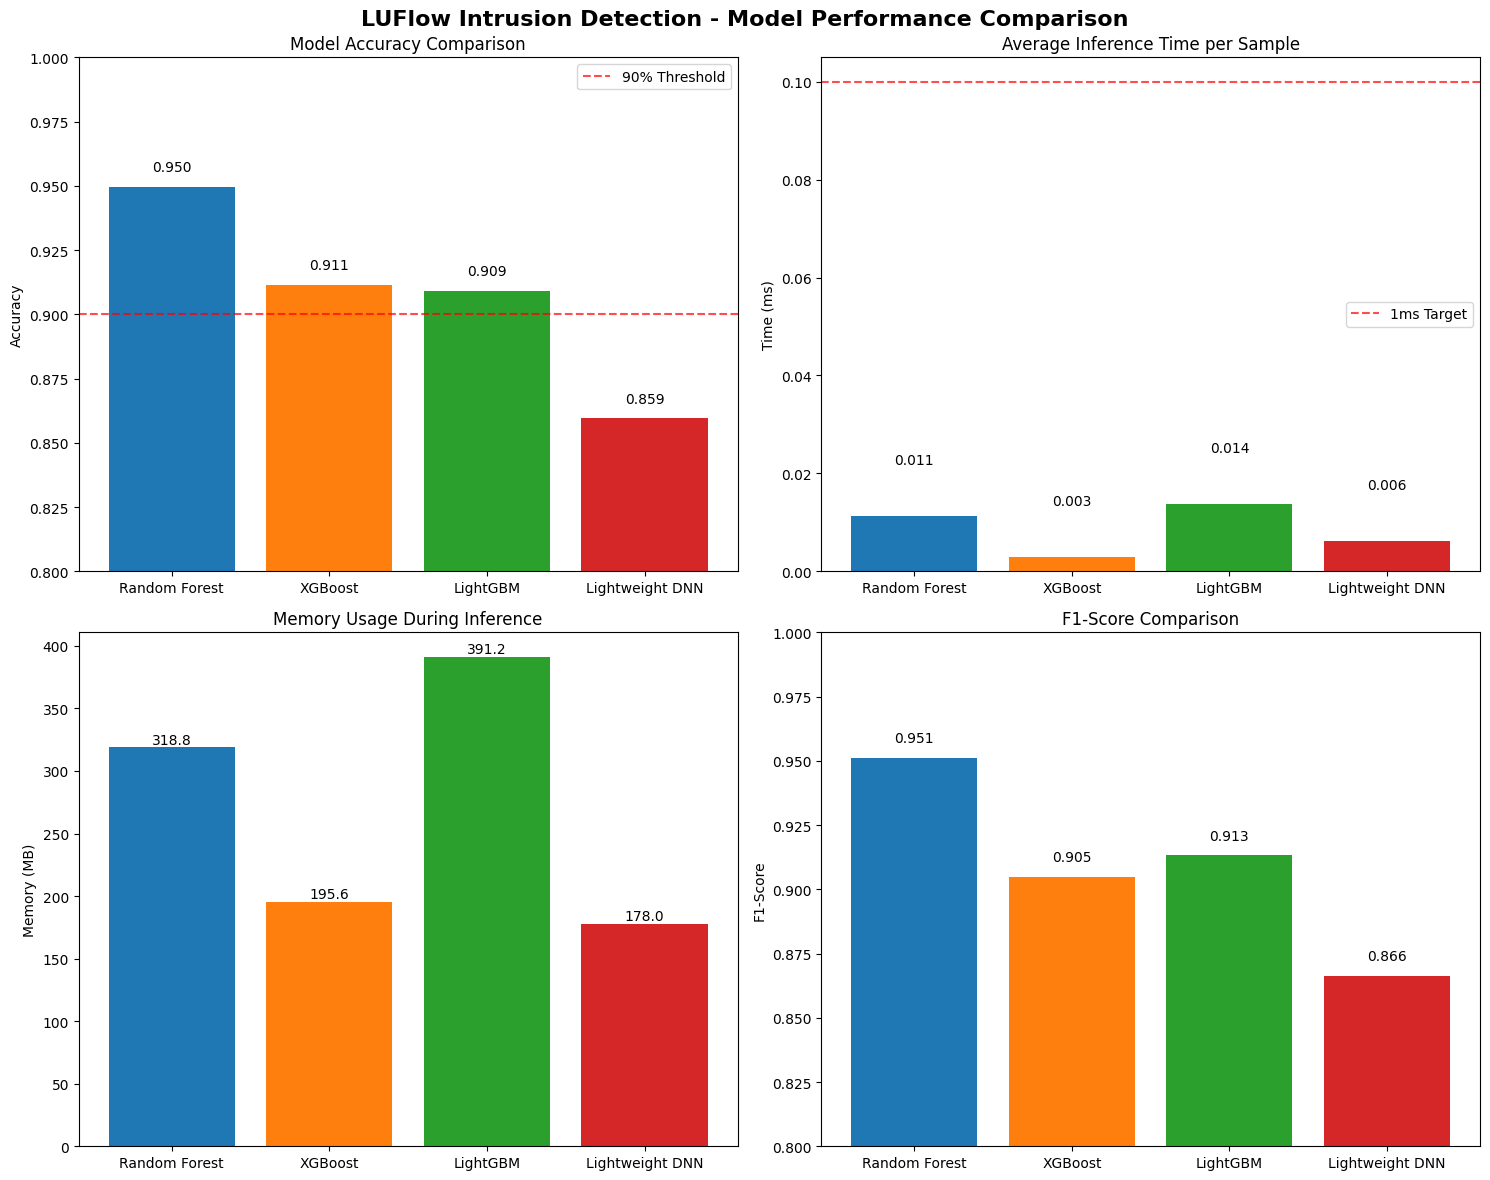

In [13]:
# Create comprehensive performance plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('LUFlow Intrusion Detection - Model Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Accuracy Comparison
models = display_df['Model']
accuracies = display_df['Accuracy']

bars1 = axes[0, 0].bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].axhline(y=0.90, color='red', linestyle='--', alpha=0.7, label='90% Threshold')
axes[0, 0].legend()
axes[0, 0].set_ylim(0.8, 1.0)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{acc:.3f}', ha='center', va='bottom')

# Plot 2: Inference Time Comparison
inference_times = display_df['Avg_Inference_ms_per_sample']

bars2 = axes[0, 1].bar(models, inference_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_title('Average Inference Time per Sample')
axes[0, 1].set_ylabel('Time (ms)')
axes[0, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='1ms Target')
axes[0, 1].legend()

# Add value labels on bars
for bar, time_val in zip(bars2, inference_times):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{time_val:.3f}', ha='center', va='bottom')

# Plot 3: Memory Usage Comparison
memory_usage = display_df['Memory_Used_MB']

bars3 = axes[1, 0].bar(models, memory_usage, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_title('Memory Usage During Inference')
axes[1, 0].set_ylabel('Memory (MB)')

# Add value labels on bars
for bar, mem in zip(bars3, memory_usage):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{mem:.1f}', ha='center', va='bottom')

# Plot 4: F1-Score Comparison
f1_scores = display_df['F1_Score']

bars4 = axes[1, 1].bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 1].set_title('F1-Score Comparison')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim(0.8, 1.0)

# Add value labels on bars
for bar, f1 in zip(bars4, f1_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Rotate x-labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)


In [14]:
print("="*80)
print("OBJECTIVE 1 RESULTS: MULTI-MODEL BENCHMARKING & SELECTION")
print("="*80)

# Calculate efficiency score (accuracy/inference_time ratio)
display_df['Efficiency_Score'] = display_df['Accuracy'] / display_df['Avg_Inference_ms_per_sample']

print("\nModel Rankings by Different Criteria:")
print("-" * 50)

print("\n1. ACCURACY (≥90% requirement):")
accuracy_ranked = display_df.sort_values('Accuracy', ascending=False)
for idx, row in accuracy_ranked.iterrows():
    status = "✓" if row['Accuracy'] >= 0.90 else "✗"
    print(f"   {status} {row['Model']}: {row['Accuracy']:.4f}")

print("\n2. INFERENCE SPEED (≤5ms target):")
speed_ranked = display_df.sort_values('Avg_Inference_ms_per_sample', ascending=True)
for idx, row in speed_ranked.iterrows():
    status = "✓" if row['Avg_Inference_ms_per_sample'] <= 5.0 else "✗"
    print(f"   {status} {row['Model']}: {row['Avg_Inference_ms_per_sample']:.4f} ms/sample")

print("\n3. MEMORY EFFICIENCY:")
memory_ranked = display_df.sort_values('Memory_Used_MB', ascending=True)
for idx, row in memory_ranked.iterrows():
    print(f"   • {row['Model']}: {row['Memory_Used_MB']:.2f} MB")

print("\n4. OVERALL EFFICIENCY (Accuracy/Speed Ratio):")
efficiency_ranked = display_df.sort_values('Efficiency_Score', ascending=False)
for idx, row in efficiency_ranked.iterrows():
    print(f"   • {row['Model']}: {row['Efficiency_Score']:.2f}")

# Final recommendations
print("\n" + "="*60)
print("DEPLOYMENT RECOMMENDATIONS")
print("="*60)

qualified_models = display_df[display_df['Accuracy'] >= 0.90]
if len(qualified_models) > 0:
    # Best overall model (meeting accuracy + fastest)
    if len(qualified_models[qualified_models['Avg_Inference_ms_per_sample'] <= 5.0]) > 0:
        best_model = qualified_models[qualified_models['Avg_Inference_ms_per_sample'] <= 5.0].iloc[0]
        print(f"\n🏆 RECOMMENDED FOR EDGE DEPLOYMENT: {best_model['Model']}")
        print(f"   ✓ Accuracy: {best_model['Accuracy']:.4f} (≥90%)")
        print(f"   ✓ Speed: {best_model['Avg_Inference_ms_per_sample']:.4f} ms/sample (≤5ms)")
        print(f"   • Memory: {best_model['Memory_Used_MB']:.2f} MB")
        print(f"   • F1-Score: {best_model['F1_Score']:.4f}")
    else:
        best_model = qualified_models.iloc[0]
        print(f"\n🥇 BEST ACCURACY MODEL: {best_model['Model']}")
        print(f"   ✓ Accuracy: {best_model['Accuracy']:.4f}")
        print(f"   ⚠ Speed: {best_model['Avg_Inference_ms_per_sample']:.4f} ms/sample (>5ms target)")
        print(f"   • Memory: {best_model['Memory_Used_MB']:.2f} MB")

    fastest_qualified = qualified_models.loc[qualified_models['Avg_Inference_ms_per_sample'].idxmin()]
    print(f"\n🚀 FASTEST QUALIFIED MODEL: {fastest_qualified['Model']}")
    print(f"   • Speed: {fastest_qualified['Avg_Inference_ms_per_sample']:.4f} ms/sample")
    print(f"   • Accuracy: {fastest_qualified['Accuracy']:.4f}")
else:
    print("\n⚠️  NO MODELS MEET 90% ACCURACY REQUIREMENT")
    print("   Consider hyperparameter tuning or feature engineering")

print(f"\n📊 DATASET STATS:")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Features: {len(X_train.columns)}")
print(f"   • Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")


OBJECTIVE 1 RESULTS: MULTI-MODEL BENCHMARKING & SELECTION

Model Rankings by Different Criteria:
--------------------------------------------------

1. ACCURACY (≥90% requirement):
   ✓ Random Forest: 0.9497
   ✓ XGBoost: 0.9113
   ✓ LightGBM: 0.9091
   ✗ Lightweight DNN: 0.8595

2. INFERENCE SPEED (≤5ms target):
   ✓ XGBoost: 0.0030 ms/sample
   ✓ Lightweight DNN: 0.0062 ms/sample
   ✓ Random Forest: 0.0114 ms/sample
   ✓ LightGBM: 0.0137 ms/sample

3. MEMORY EFFICIENCY:
   • Lightweight DNN: 178.02 MB
   • XGBoost: 195.64 MB
   • Random Forest: 318.76 MB
   • LightGBM: 391.24 MB

4. OVERALL EFFICIENCY (Accuracy/Speed Ratio):
   • XGBoost: 303.14
   • Lightweight DNN: 138.62
   • Random Forest: 83.41
   • LightGBM: 66.54

DEPLOYMENT RECOMMENDATIONS

🏆 RECOMMENDED FOR EDGE DEPLOYMENT: Random Forest
   ✓ Accuracy: 0.9497 (≥90%)
   ✓ Speed: 0.0114 ms/sample (≤5ms)
   • Memory: 318.76 MB
   • F1-Score: 0.9512

🚀 FASTEST QUALIFIED MODEL: XGBoost
   • Speed: 0.0030 ms/sample
   • Accuracy: 